In [1]:
##################
## Load Imports ##
##################

import numpy as np
from numpy.linalg import inv
from scipy.stats import multivariate_normal

import plotting_helpers
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

np.random.seed(111)

# 1 Bayesian Linear Regression

In this exercise, we will consider Bayesian linear regression.

Exercises:
1. Calculate and implement the posterior distribution (Section 1.3).
1. (Optional) Bonus exercises (Section 1.5).

## 1.1 Preparing Toy Data

We first load imports and prepare a 1D toy dataset for regression.

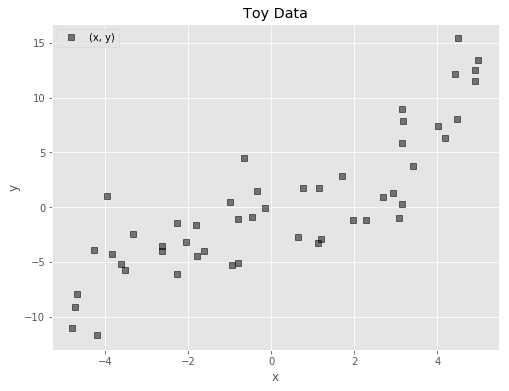

In [2]:
#####################
## Sample Toy Data ##
#####################

def toyData(N, sigma, seed=111):
    np.random.seed(seed)
    x = np.random.uniform(-5, 5, size=N)
    np.random.seed(seed)
    y = 0.1 * x**3 + np.random.normal(0.0, sigma, size=N)
    return x, y

N = 50
sigma = 3.0

x, y = toyData(N, sigma)

plotting_helpers.plot_toy_data(x, y)

## 1.2 Model Specification
The linear model is given by 
$$y = xw + b + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \tau^{-1}),$$
where $\tau$ is the noise precision, $w$ is the slope and $b$ is the intercept. Let $\theta = (w,b)$ denote the combined parameters.  
Assume futher that we have $N$ data points $\mathcal{D} = \{(x_n,y_n)\}_{n=1}^N$.

### 1.2.1 Specifying the Liklihood

The likelihood of the model is then given by
$$p(\mathcal{D} | \theta)  = \prod_{n=1}^N \mathcal{N}(y_n | x_n w + b, \tau^{-1}).$$

### 1.2.2 Specifying the Prior

The typical choice of prior is also a Gaussian,
$$p(\theta) = \mathcal{N}(\theta | 0, \lambda^{-1} \boldsymbol{I}),$$
where $\lambda$ is the prior precision. This prior is conjugate to the Gaussian likelihood, such that the posterior can be written in closed-form.

In [3]:
#####################
## Construct Prior ##
#####################

lam = 1.0 # Prior precision

mu_prior = np.zeros([2])
Sigma_prior = np.eye(2) / lam

prior =  multivariate_normal(mean = mu_prior, 
                             cov = Sigma_prior)

## 1.3 Posterior Inference (Exercise 1)

Using the prior and the likelihood, we can compute the posterior distribution using Bayes rule
$$p(\theta | \mathcal{D}) = \frac{p(\theta) p(\mathcal{D} | \theta)}{p(\mathcal{D})}.$$

Exercise 1:
* Calculate and implement the posterior distribution for $p(\theta | \mathcal{D})$.

### 1.3.1 Solution
The posterior distribution is Gaussian $p(\theta | \mathcal{D}) = \mathcal{N}(\theta | \mu, \Sigma)$, with
$$\Sigma^{-1} = \lambda I + \tau X^T X$$
$$\mu = \tau \Sigma X^T y,$$
where $X$ is the design matrix and $y$ is a vector of all the observations.


In [4]:
#########################
## Construct Posterior ##
#########################

tau = 0.05 # Noise precision

# Prepare "design matrix" with a column of ones
X = np.concatenate((x.reshape(-1,1), np.ones(len(x)).reshape(-1,1)),axis=1)

def compute_posterior(X, y, mu_prior, Sigma_prior):
    Sigma_posterior = inv(inv(Sigma_prior) + tau * X.T @ X)
    mu_posterior = tau * Sigma_posterior @ X.T @ y

    return multivariate_normal(mean=mu_posterior, cov=Sigma_posterior)

posterior = compute_posterior(X, y, mu_prior, Sigma_prior)

## 1.4 Visualizations

### 1.4.1 Visualizing the Posterior

We first visualize the prior and the posterior distribution over $\theta$.

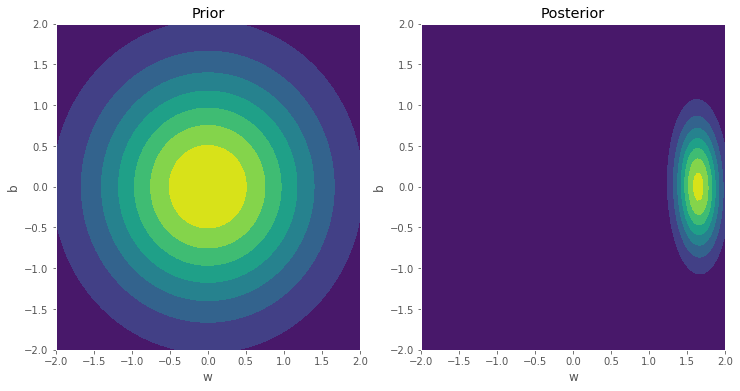

In [5]:
plotting_helpers.plot_prior_and_posterior(prior, posterior)

### 1.4.2 Visualizing Predictions

Next we sample from the prior and the posterior and plot the sampled lines.

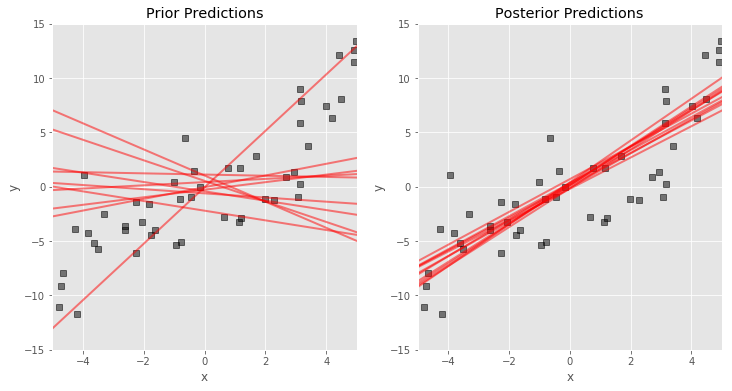

In [6]:
########################
## Sample Predictions ##
########################

num_preds = 10
resolution = 2
x_pred = np.linspace(-5, 5, num=resolution)

def sample_predictions(x_pred, parameter_distribution, num_preds):
    parameter_samples = parameter_distribution.rvs(num_preds)
    y_pred = np.zeros([num_preds, len(x_pred)])
    for i in range(num_preds):
        y_pred[i] = parameter_samples[i,0] * x_pred + parameter_samples[i,1]
    return y_pred

prior_preds = sample_predictions(x_pred, prior, num_preds)
posterior_preds = sample_predictions(x_pred, posterior, num_preds)

######################
## Plot Predictions ##
######################

plotting_helpers.plot_prior_and_posterior_predictions(x, y, x_pred, prior_preds, posterior_preds)

## 1.5 Bonus Exercises

### 1.5.1 The Effect of More Data

Exercise:
* What effect does adding more data points have on the posterior? 

In [7]:
######################
## Interactive Plot ##
######################

def f(N):
    print(N)
    x, y = toyData(N, sigma, seed=111)
    np.random.seed(111)
    X = np.concatenate((x.reshape(-1,1), np.ones(len(x)).reshape(-1,1)),axis=1)
    posterior = compute_posterior(X, y, mu_prior, Sigma_prior)
    prior_preds = sample_predictions(x_pred, prior, num_preds)
    posterior_preds = sample_predictions(x_pred, posterior, num_preds)
    plotting_helpers.plot_prior_and_posterior_predictions(x, y, x_pred, prior_preds, posterior_preds)

interact(f, N=widgets.IntSlider(min=5,max=100,step=5,value=N,continuous_update=False))


interactive(children=(IntSlider(value=50, continuous_update=False, description='N', min=5, step=5), Output()),…

<function __main__.f>

### 1.5.2 The Predictive Distribution

Exercises:
1. Actually, we don't need to sample from the posterior to obtain predictions.
The predictive distribution 
$$p(y|x,\mathcal{D}) = \int p(y | x, \theta) p(\theta | \mathcal{D}) d\theta$$
can be computed in closed-form. How does the predictive distribution relate to the sampled predictions above?
1. Calculate the predictive distribution $p(y|x,\mathcal{D})$.

### 1.5.3 Fully Bayesian Linear Regression

1. What is the conjugate prior for the combined parameters ($\theta$, $\tau$)? How would this model differ from the case above where we considered $\tau$ to be constant?